# Metadata

Data from:
[Google Sheet](https://docs.google.com/spreadsheets/d/1Oh7zeWlQewzo9bDmnu5cenVM5a9zddVSlzS5OcUnhaE/edit?gid=801397250#gid=801397250)

Want to understand the samples:
- How many for each year
- Start and end dates
- Length of samples
- Repeats
- DNA yields

Could also look at contig stats files also in metadata


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.parser import parse
from matplotlib.ticker import LogLocator, ScalarFormatter

Quite messy metadata so filling in some gaps for plotting 
- When there is no date I am going to use 15
- When there is no start_time I am going to use 10:00
- Adding a missing_date and missing_time col to keep track of this as well as leaving the original columns
- Have a BST_GMT column which I m going to use to adjust the start times before combining
- New DateTime_UTC is the one I should be using as 'start time'

Saving this output so i can use it in other analysis e.g. stacked bar chart in R


In [2]:
import pandas as pd

def parse_metadata(df):

    # Fill missing dates with the 15th of the month - currently DD in the metadata
    df.loc[df['Date_Collected'].str.contains('DD', na=False), 'Date_Collected'] = df['Date_Collected'].str.replace('DD', '15')
  
    # Convert Date_Collected to datetime
    df['Date_Collected'] = pd.to_datetime(df['Date_Collected'], format='%d/%m/%y', errors='coerce')

    # Fill missing Start_Time with 10:00
    df['Start_Time'] = df['Start_Time'].fillna('10:00')

    # Convert Start_Time to timedelta for calculations
    df['Start_Time'] = pd.to_timedelta(df['Start_Time'] + ':00')  # Ensuring HH:MM:SS format

    # Combine Date and Time
    df['DateTime_UTC'] = df['Date_Collected'] + df['Start_Time']

    # Adjust for BST (convert BST times to UTC)
    df.loc[df['BST_GMT'] == 'BST', 'DateTime_UTC'] -= pd.Timedelta(hours=1)

    # Ensure final DateTime is in proper format
    df['DateTime_UTC'] = pd.to_datetime(df['DateTime_UTC'], errors='coerce')

    return df

def clean_sample_id(sample_id):
    if pd.isna(sample_id):
        return sample_id
    if ':' in sample_id:
        return sample_id.split(':')[1].strip()
    return sample_id.strip()

def transform_sample_id(sample_id):
    # Skip transformation if sample_id is NaN or empty
    if pd.isna(sample_id) or sample_id.strip() == '':
        return sample_id

    # Handle specific cases
    specific_cases = {
        'May_10_12_1': '14_05_24_(1)',
        'May_10_12_2': '14_05_24_(2)',
        'June_10_12_1': '18_06_24_(1)',
        'June_10_12_2': '18_06_24_(2)',
        'ChurchFarm1_Jul24': '25_07_24_(1)',
        'ChurchFarm2_Jul24': '25_07_24_(2)',
        'ChurchFarm1_Oct24': '17_10_24_(1)',
        'ChurchFarm2_Oct24': '17_10_24_(2)',
        'Reg_57_Pos' : 'Positive',
        'Reg_65_Neg' : 'Negative',
        # Add more specific cases here if needed
    }
    if sample_id in specific_cases:
        return specific_cases[sample_id]

    # General transformation for IDs like Reg_1_031022
    if sample_id.startswith('Reg_'):
        parts = sample_id.split('_')
        if len(parts) == 3:
            # Extract the date and reformat it
            date_part = parts[2]
            if len(date_part) == 6:  # Ensure the date part is in DDMMYY format
                day = date_part[:2]
                month = date_part[2:4]
                year = date_part[4:]
                repeat = metadata.loc[metadata['Sample_ID'] == sample_id, 'Repeat'].values[0]
                return f"{day}_{month}_{year}_({repeat})"
    return sample_id  # Return as-is if it doesn't match the expected format


# Read in data
metadata = pd.read_csv('/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/metadata/All metadata - Regular CF collections (2023 & 2024).tsv', sep='\t')  

# Clean dates
metadata = parse_metadata(metadata)
# Clean the Sample_ID column
metadata['Sample_ID'] = metadata['Sample_ID'].apply(clean_sample_id)

#Order by date
metadata = metadata.sort_values(by='Date_Collected')
# Reset index after sorting
metadata.reset_index(drop=True, inplace=True)
# Add a repeat column to differentiate samples collected on the same date
metadata['Repeat'] = metadata.groupby('Date_Collected').cumcount() + 1
# Convert the Repeat column to integer, handling NaN values
metadata['Repeat'] = metadata['Repeat'].fillna(0).astype(int)

# Generate a new column Nice_ID based on transformed Sample_ID
metadata['Nice_ID'] = metadata['Sample_ID'].apply(transform_sample_id)

# Generate Sample column for grouping 
metadata['Sample'] = metadata['Nice_ID'].str.split('_').str[:3].str.join('_')

# Clean the 'Year' column by replacing non-numeric values with NaN and dropping them
metadata['Year'] = pd.to_numeric(metadata['Year'], errors='coerce').dropna().astype(int)

In [3]:
metadata.columns

Index(['Sample_ID', 'Sampler_Used', 'Notes', 'Location', 'Year', 'BST_GMT',
       'Date_Collected', 'Missing_Date', 'Missing_Time', 'Start_Time',
       'End_Time', 'Collection_Length_Min', 'DNA_Concentration_(ng/ul)', 'WGA',
       'DNA_Concentration_WGA_(ng/ul)', 'Location_96_well_plate', 'Barcode',
       'DateTime_UTC', 'Repeat', 'Nice_ID', 'Sample'],
      dtype='object')

In [6]:
# metadata.to_csv('../metadata/metadata_cleaned.tsv', sep='\t', index=False)


## Calculate some stats from the metadata

- How many samples per year (and month)
- Earliest and latest sample from each year
- Plot of DNA yield (maybe hue by Collection_Length_Min)

In [6]:
# How many samples are there?
print(f'There are {metadata.shape[0]} samples in the dataset')

# How many unique Sample_IDs are there? (2xNaNs)
print(f'There are {metadata["Sample_ID"].nunique()} unique Sample_IDs in the dataset')

#How many samples are there for each year
metadata['Year'] = metadata['DateTime_UTC'].dt.year
print(metadata['Year'].value_counts())

# How many samples are there for each month
metadata['Month'] = metadata['DateTime_UTC'].dt.strftime('%b')
# How many samples are there for each month by year
print(metadata.groupby(['Year', 'Month']).size().unstack(fill_value=0))

There are 107 samples in the dataset
There are 105 unique Sample_IDs in the dataset
Year
2024.0    64
2023.0    33
2022.0     6
Name: count, dtype: int64
Month   Apr  Aug  Dec  Feb  Jan  Jul  Jun  Mar  May  Nov  Oct  Sep
Year                                                              
2022.0    0    0    2    0    0    0    0    0    0    2    2    0
2023.0    2    6    0    2    2    8    9    2    2    0    0    0
2024.0    8    8    0    8    0   10    6    8    6    0    2    8


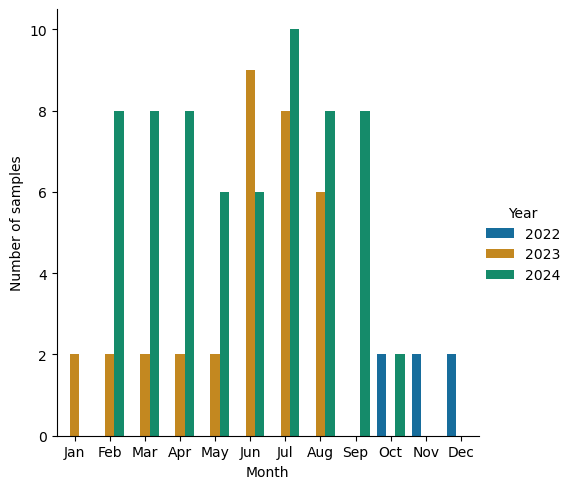

In [7]:
metadata['Year'] = metadata['Year'].astype(str).str.split('.').str[0]  # Clean 'Year'
fil_metadata = metadata[(metadata['Year'] != 'nan')]


# Plot the number of samples by month
sns.catplot(data=fil_metadata,
            x='Month',
            kind='count',
            order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
            hue='Year',
            palette='colorblind')

ylabel = plt.ylabel('Number of samples')
# plt.savefig('../Graphs/Number_of_samples_by_month.pdf')

## DNA yield

- consider pre and post WGA
- 2023 - WGA
- 2024 no WGA just initial DNA conc

In [8]:
columns_to_convert = ['DNA_Concentration_(ng/ul)', 'DNA_Concentration_WGA_(ng/ul)']

for column in columns_to_convert:
    fil_metadata[column] = pd.to_numeric(fil_metadata[column], errors='coerce')

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_52748/3576719391.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fil_metadata[column] = pd.to_numeric(fil_metadata[column], errors='coerce')


/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_52748/2894980766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fil_metadata['Collection_Length_Min'] = fil_metadata['Collection_Length_Min'].astype(str).str.split('.').str[0]  # Clean 'Year'


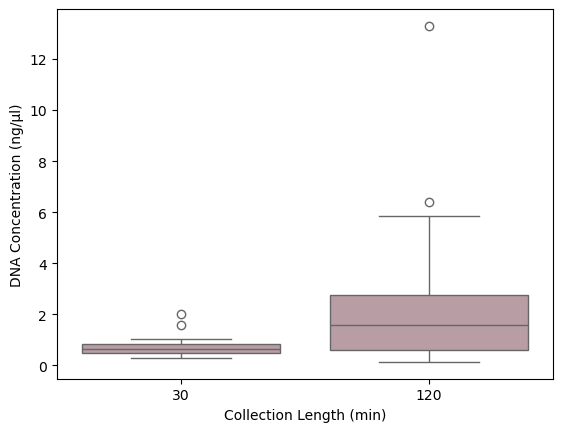

In [9]:
fil_metadata['Collection_Length_Min'] = fil_metadata['Collection_Length_Min'].astype(str).str.split('.').str[0]  # Clean 'Year'

# Filter out samples with Collection_Length_Min equal to 60
fil_metadata = fil_metadata[fil_metadata['Collection_Length_Min'] != '60']

sns.boxplot(
    data=fil_metadata,
    x='Collection_Length_Min',
    y='DNA_Concentration_(ng/ul)',
    color='#BD98A2',
)

ylabel = plt.ylabel('DNA Concentration (ng/μl)')
xlabel = plt.xlabel('Collection Length (min)')
plt.savefig('../Graphs/DNA_concentration_vs_collection_length.pdf')

Plot boxplot, have DNA concentration pre and post WGA for the 30-minute samples

In [10]:
# melt the data so DNA concentration and WGA 
# First, reshape the DNA concentrations into long format
df_melted = pd.melt(
    fil_metadata,
    id_vars=["Sample_ID", "Collection_Length_Min"],  # Keep these as identifiers
    value_vars=[
        "DNA_Concentration_(ng/ul)",
        "DNA_Concentration_WGA_(ng/ul)"
    ],
    var_name="Measurement",
    value_name="DNA_Concentration"
)

# Then, create a new column to assign the correct WGA label
def label_group(row):
    if row["Measurement"] == "DNA_Concentration_(ng/ul)":
        if row["Collection_Length_Min"] == "30":
            return "30-min no WGA"
        elif row["Collection_Length_Min"] == "120":
            return "120-min no WGA"
    elif row["Measurement"] == "DNA_Concentration_WGA_(ng/ul)":
        if row["Collection_Length_Min"] == "30":
            return "30-min post-WGA"
    return None  # filter out anything unmatched

df_melted["Group"] = df_melted.apply(label_group, axis=1)

# Filter to keep only relevant groups
df_filtered = df_melted[df_melted["Group"].notnull()]

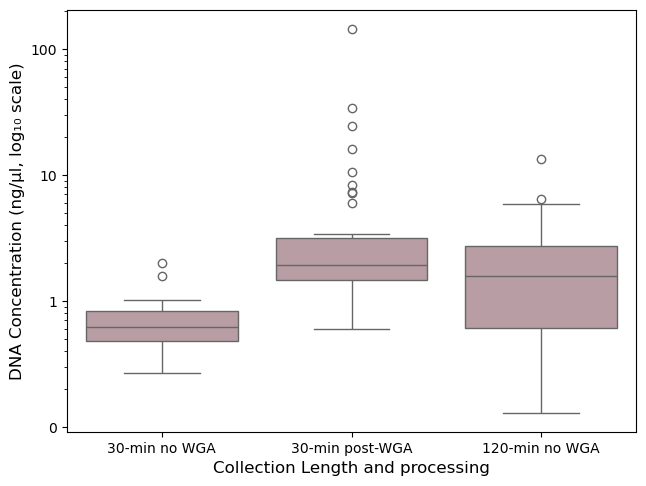

In [31]:
sns.boxplot(
    data=df_filtered,
    x='Group',
    y='DNA_Concentration',
    order=['30-min no WGA', '30-min post-WGA', '120-min no WGA'],
    color='#BD98A2',  # Set a specific color for the boxplot 
)

plt.yscale('log')
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.tick_params(axis='both', which='major', labelsize=10)  # Set tick label font size
plt.xlabel('Collection Length and processing', fontsize=12)  # Axis label font size
plt.ylabel('DNA Concentration (ng/μl, log₁₀ scale)', fontsize=12)

plt.tight_layout(pad=0.5)
plt.savefig('../Graphs/DNA_concentration_vs_collection_length_WGA.pdf')

Some DNA yield numbers

In [49]:
# Print the range and number of NaN for DNA_Concentration_(ng/ul) for 2023 and 2024 samples
for year in ['2023', '2024']:
    subset = fil_metadata[fil_metadata['Year'] == year]['DNA_Concentration_(ng/ul)']
    non_na = subset.dropna()
    print(f"{year}: min={non_na.min() if not non_na.empty else 'NA'}, max={non_na.max() if not non_na.empty else 'NA'}, NaN count={subset.isna().sum()}")

2023: min=0.268, max=2.01, NaN count=8
2024: min=0.13, max=13.3, NaN count=5


In [51]:
# Print the range and number of NaN for DNA_Concentration_(ng/ul) for 2023 and 2024 samples
for year in ['2023', '2024']:
    subset = fil_metadata[fil_metadata['Year'] == year]['DNA_Concentration_WGA_(ng/ul)']
    non_na = subset.dropna()
    print(f"{year}: min={non_na.min() if not non_na.empty else 'NA'}, max={non_na.max() if not non_na.empty else 'NA'}, NaN count={subset.isna().sum()}")

2023: min=0.603, max=144.0, NaN count=0
2024: min=NA, max=NA, NaN count=60


Looking at the samples which had below detectable DNA, but the  May_10_12_1 etc, samples from 2024 are appearing as NA becuase they are imported froma another experiment and this metadata is missing. 

In [58]:
filtered_2023 = fil_metadata[(fil_metadata['Year'] == '2023') & (fil_metadata['DNA_Concentration_(ng/ul)'].isna())]
print(filtered_2023[['Sample_ID', 'DNA_Concentration_(ng/ul)', 'DNA_Concentration_WGA_(ng/ul)']])

        Sample_ID  DNA_Concentration_(ng/ul)  DNA_Concentration_WGA_(ng/ul)
7    Reg_8_010123                        NaN                          0.992
8    Reg_9_010223                        NaN                          2.410
9   Reg_10_010223                        NaN                          1.860
10  Reg_11_010323                        NaN                          0.603
11  Reg_12_010323                        NaN                         10.600
17  Reg_18_020623                        NaN                          0.931
29  Reg_30_200723                        NaN                          0.838
30  Reg_31_200723                        NaN                          1.750


## Sequence statistics 
Compare 2023 & 2024 classification
- Look at classified yield for the different runs 
- Merge with metadata to compare with DNA Yield and year collected
- Also read in contig stats

In [12]:
read_nos = pd.read_csv('/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/metadata/read_numbers.tsv', sep='\t')
read_nos = read_nos.rename(columns={'ID': 'Sample_ID'})

- Need to merge on the metadata to get sample IDs, by barcode & year
- don't have the contig stats for Norfolk seq / 24 hr samples immediately to hand

In [13]:
contig_stats_24 = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/metadata/2024/combined_200k_noML_contig_stats.tsv", sep="\t")
contig_stats_24['Barcode'] = contig_stats_24['Barcode'].str.extract(r'(\d{2})$').astype(int)
contig_stats_24['Year'] = 2024

contig_stats_23 = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/metadata/2023/200k_combined_contig_stats.tsv", sep="\t")
contig_stats_23['Barcode'] = contig_stats_23['Barcode'].str.extract(r'(\d{2})$').astype(int)
# Barcodes 1 - 6 were collected in 2022
contig_stats_23['Year'] = contig_stats_23['Barcode'].apply(lambda x: 2022 if x <= 6 else 2023)

contig_stats = pd.concat([contig_stats_24, contig_stats_23], ignore_index=True)

In [ ]:
# Make Year string for merging
contig_stats['Year'] = contig_stats['Year'].astype(str)

# Merge with barcode & contig_stats on 'Year' and 'Barcode'
metadata_ex = metadata.merge(contig_stats, on=['Year', 'Barcode'], how='left')

#Merge with read numbers on Sample_ID
metadata_ex = metadata_ex.merge(read_nos, on='Sample_ID', how='left')

# New year processed column 
metadata_ex['Year_Processed'] = metadata_ex['Year'].apply(lambda x: 2023 if x == 2022 else x)

### Plot distribution of read metrics
- colour by Year
- faceted plot of the contig stats metrics
- different plot for MARTi data

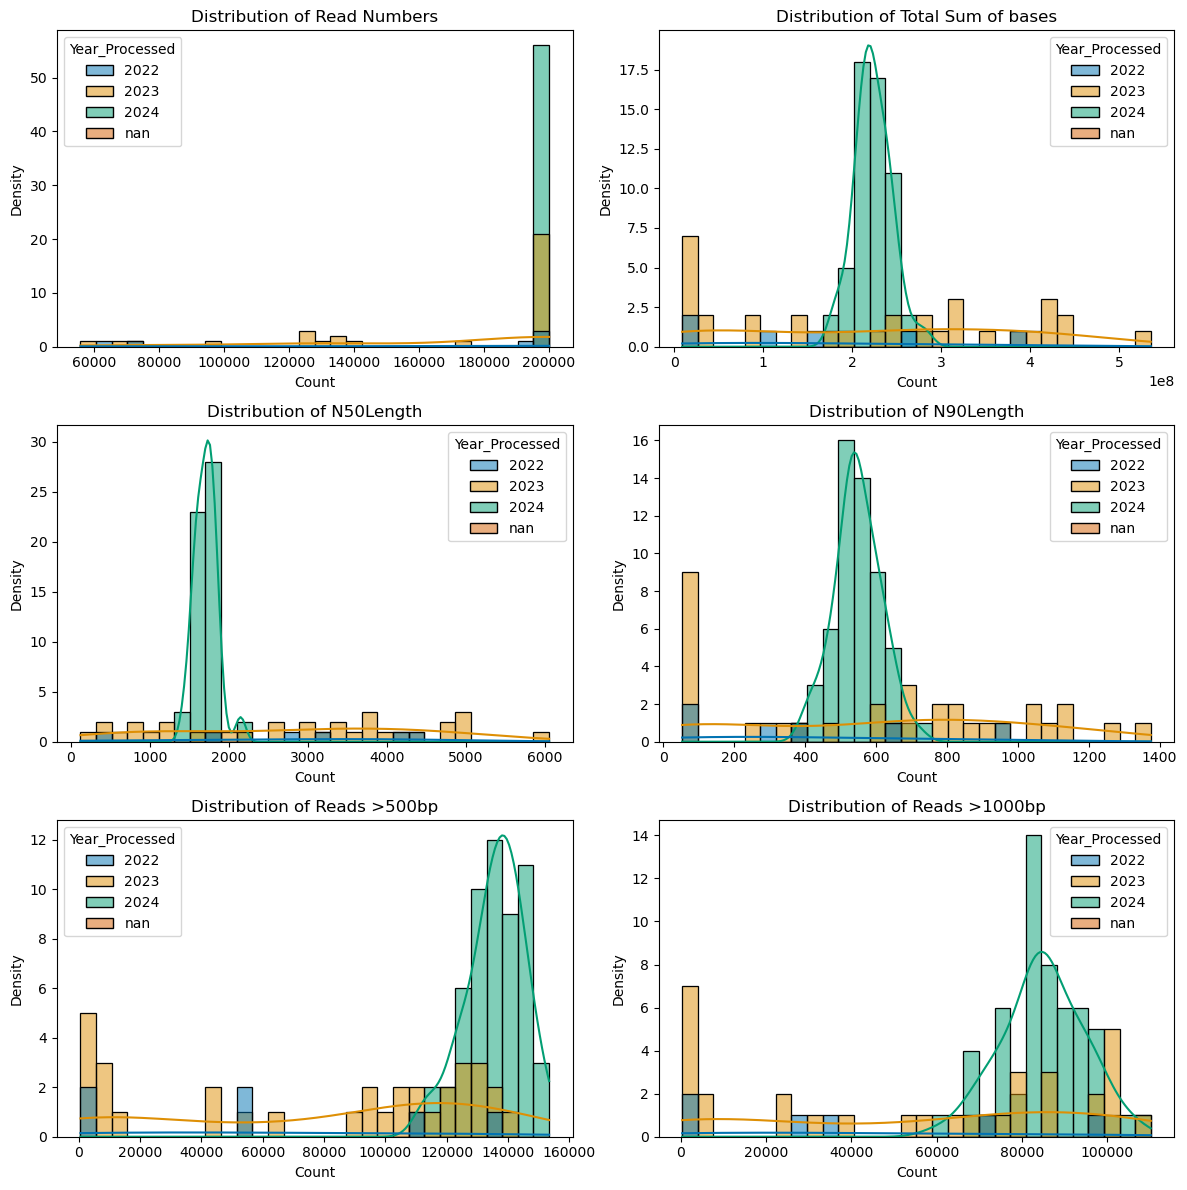

In [19]:
# Function to plot distribution of read metrics 
def plot_read_metrics(metadata_ex, metric, ylabel, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=metadata_ex, x=metric, bins=30, kde=True, hue='Year_Processed', palette='colorblind')
    plt.xlabel('Count')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# Save the plots into a faceted plot
metrics = ['NumContigs', 'TotalSum', 'N50Length', 'N90Length', 'GE500Count', 'GE1000Count']
titles = [
    'Distribution of Read Numbers',
    'Distribution of Total Sum of bases',
    'Distribution of N50Length',
    'Distribution of N90Length',
    'Distribution of Reads >500bp',
    'Distribution of Reads >1000bp'
]

# Create a faceted plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.histplot(
        data=metadata_ex,
        x=metric,
        bins=30,
        kde=True,
        hue='Year_Processed',
        palette='colorblind',
        ax=axes[i]
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('Density')

# Adjust layout
plt.tight_layout()
# plt.savefig('../Graphs/faceted_contig_stats_metrics_plot.svg')
plt.show()


Not going to plot ReadsPassBasecall as it is basically the same as NumContigs, only difference is from the samples where i am missing contig stats

In [20]:
mismatched_rows = metadata_ex[metadata_ex['NumContigs'] != metadata_ex['ReadsPassBasecall']]
print(mismatched_rows[['Sample_ID', 'NumContigs', 'ReadsPassBasecall']])

             Sample_ID  NumContigs  ReadsPassBasecall
63         May_10_12_1         NaN           200000.0
64         May_10_12_2         NaN           200000.0
71        June_10_12_1         NaN           200000.0
72        June_10_12_2         NaN           200000.0
83   ChurchFarm1_Jul24         NaN           200000.0
84   ChurchFarm2_Jul24         NaN           200000.0
101  ChurchFarm1_Oct24         NaN           200000.0
102  ChurchFarm2_Oct24         NaN           200000.0
103                NaN         NaN                NaN
104                NaN         NaN                NaN
105         Reg_57_Pos         NaN           200000.0
106         Reg_65_Neg         NaN                4.0


/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/berelsom/opt/anaconda3/envs/24hr_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

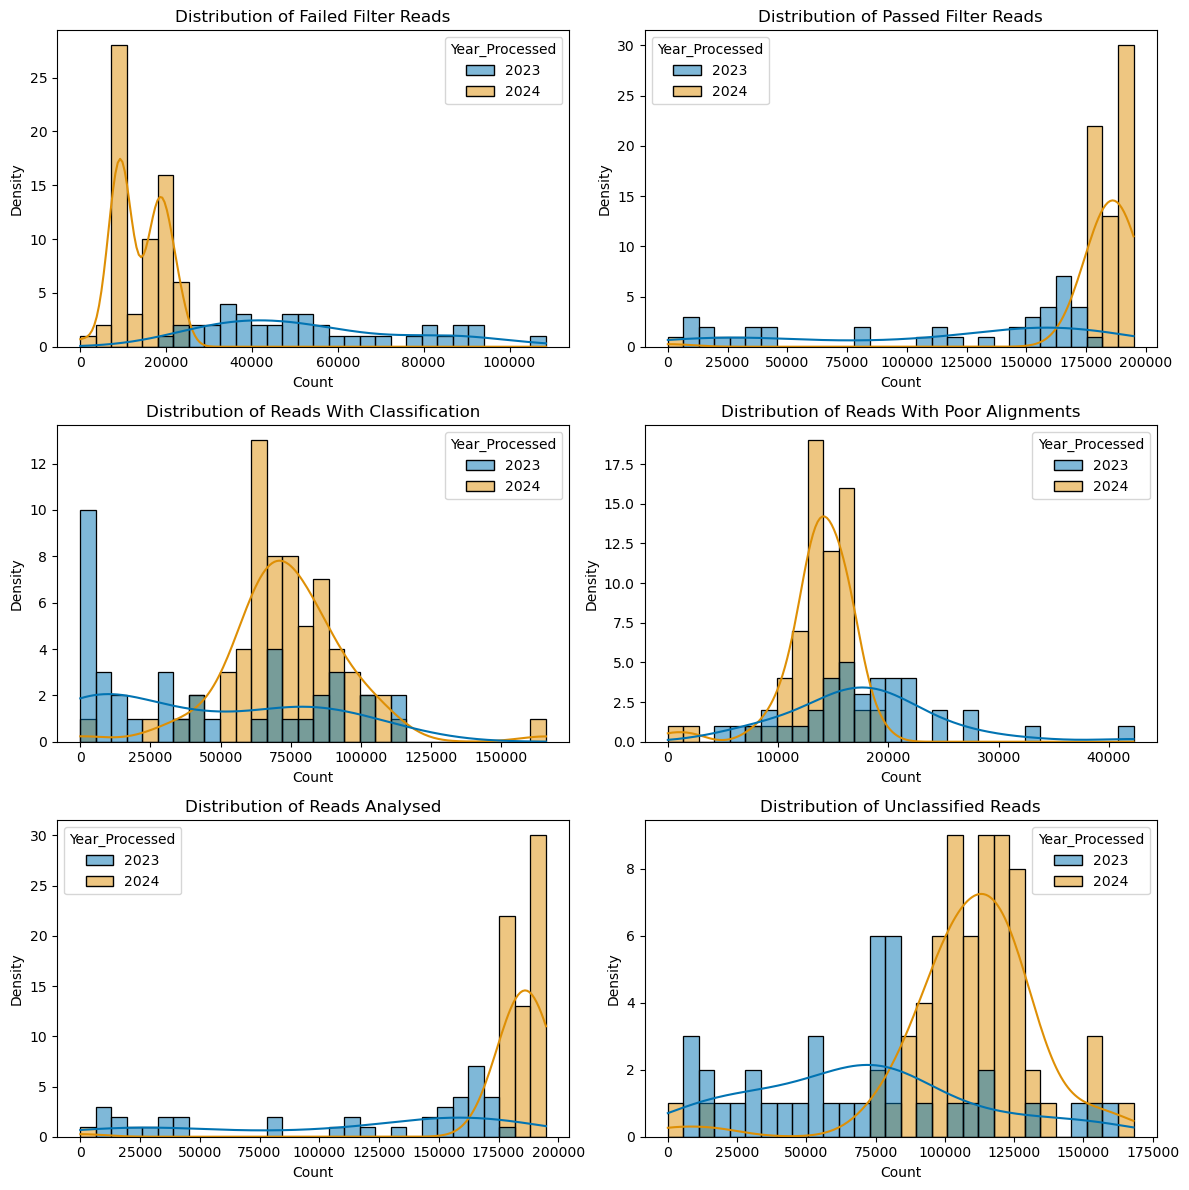

In [77]:
# Function to plot distribution of read metrics 
def plot_read_metrics(metadata_ex, metric, ylabel, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=metadata_ex, x=metric, bins=30, kde=True, hue='Year_Processed', palette='colorblind')
    plt.xlabel('Count')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# Save the plots into a faceted plot
metrics = [
    'ReadsFailedFilter', 'ReadsPassedFilter', 'ReadsWithClassification', 
    'ReadsWithPoorAlignments', 'ReadsAnalysed', 'ReadsUnclassified']
titles = [
    'Distribution of Failed Filter Reads',
    'Distribution of Passed Filter Reads',
    'Distribution of Reads With Classification',
    'Distribution of Reads With Poor Alignments',
    'Distribution of Reads Analysed',
    'Distribution of Unclassified Reads'
]

# Create a faceted plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    sns.histplot(
        data=metadata_ex,
        x=metric,
        bins=30,
        kde=True,
        hue='Year_Processed',
        palette='colorblind',
        ax=axes[i]
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.savefig('../Graphs/faceted_read_metrics_plot.svg')
plt.show()


# Contig stats before subsampling

In [36]:
contig_2024 = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/metadata/2024/combined_contig_stats.tsv", sep="\t")


contig_2024['Barcode'] = contig_2024['Barcode'].str.extract(r'(\d{2})$').astype(int)
contig_2024['Year'] = 2024

contig_2023 = pd.read_csv("/Users/berelsom/Library/CloudStorage/OneDrive-NorwichBioScienceInstitutes/Air_Samples/Church_farm/metadata/2023/combined_contig_stats.tsv", sep="\t")
contig_2023['Barcode'] = contig_2023['Barcode'].str.extract(r'(\d{2})$').astype(int)
# Barcodes 1 - 6 were collected in 2022
contig_2023['Year'] = contig_2023['Barcode'].apply(lambda x: 2023)

contig_stats = pd.concat([contig_2024, contig_2023], ignore_index=True)

In [37]:
# Make Year string for merging
contig_stats['Year'] = contig_stats['Year'].astype(str)

# Merge with barcode & contig_stats on 'Year' and 'Barcode'
contig_meta = metadata.merge(contig_stats, on=['Year', 'Barcode'], how='left')


In [38]:
print(contig_meta.loc[contig_meta['NumContigs'] < 200000, ['Sample_ID', 'NumContigs']])

        Sample_ID  NumContigs
6    Reg_7_010123    136552.0
7    Reg_8_010123     98473.0
9   Reg_10_010223     55927.0
15  Reg_16_250523    127392.0
18  Reg_19_060623    126734.0
19  Reg_20_140623    175840.0
20  Reg_21_140623    123528.0
21  Reg_22_210623    139611.0
28  Reg_29_120723     75051.0
33  Reg_34_030823    134309.0
35  Reg_36_090823     69741.0
36  Reg_37_090823    128929.0


In [40]:
# Print the range of NumContigs for 2023 and 2024 samples
for year in ['2023', '2024']:
    subset = contig_meta[contig_meta['Year'] == year]['NumContigs'].dropna()
    if not subset.empty:
        print(f"{year}: min={subset.min()}, max={subset.max()}")
    else:
        print(f"{year}: No data available for NumContigs")

2023: min=55927.0, max=1358036.0
2024: min=244268.0, max=962001.0
